# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Importar Bibliotecas e Bases de Dados

In [149]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidar Base de Dados

In [150]:
#percorrendo todas os arquivos que contém os dados e adicionando a coluna de Mês e Ano

#obs: fiz dessa forma para treinar/estudar, pois eu poderia ter pego direto da coluna dentro do próprio dataframe

dicionario_mes = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

base_dados = pd.DataFrame()
caminho = Path()
lista_pastas = Path.iterdir(caminho / 'dataset')

for pasta in lista_pastas:
    arquivo = pd.read_csv(caminho / pasta, low_memory = False)

    nome_mes = pasta.name[:3]
    numero_mes = dicionario_mes[nome_mes]
    
    ano = pasta.name[-8:-4]
    
    arquivo['mes'] = numero_mes
    arquivo['ano'] = ano
    
    #criando uma base de dados única com todos os meses e anos
    base_dados = pd.concat([base_dados, arquivo])
    
    

### Verificando as colunas existentes e fazendo algum tratamento necessário

In [151]:
base_dados.info() # foi verificado que existem 108 colunas, então vamos exportar parte da base para o excel para vermos as colunas

#exportando a base para um csv para conseguir abrir no excel e excluir colunas inúteis
base_dados.head(200).to_csv('Primeiros Dados.csv', sep = ';') 

#deixando somente as colunas que julgo que podem impactar no preço da diária do imóvel
base_dados = base_dados.loc[:, ['host_listings_count','host_is_superhost','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','review_scores_rating','cancellation_policy','mes','ano']]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 902210 entries, 0 to 34328
Columns: 108 entries, id to calculated_host_listings_count_shared_rooms
dtypes: float64(31), int64(14), object(63)
memory usage: 750.3+ MB


Nesse caso, através do base_dados.info() foi constatado que existiam muitas colunas.
Com isso, achei válido salvar uma certa quantidade de linas (200) em um csv no excel para eu conseguir ver todas as colunas e já excluir aqueles que julguei não serem tão necessárias para o modelo.
Caso, ao final do projeto, o modelo gerado não tenha um bom índice de acerto, eu poderia rever essa parte do código para ver se retirei alguma coluna importante

### Tratar Valores Faltando

In [152]:
#optei por excluir as colunas que apresentam mais que 300000 valores vazios (cerca de 1/3 dos valores da base total)

for coluna in base_dados:
    if (base_dados[coluna].isnull().sum()) >300000:
        base_dados = base_dados.drop(columns = coluna, axis = 1)

#após excluir as colunas anteriores, optei por excluir as linhas que restaram com valores vazios
base_dados = base_dados.dropna()

#fiz essas exclusões pois temos uma base muito grande, então mesmo excluindo essas linhas, continuamos com uma base grande para trabalhar


In [153]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   host_listings_count  897709 non-null  float64
 1   host_is_superhost    897709 non-null  object 
 2   latitude             897709 non-null  float64
 3   longitude            897709 non-null  float64
 4   property_type        897709 non-null  object 
 5   room_type            897709 non-null  object 
 6   accommodates         897709 non-null  int64  
 7   bathrooms            897709 non-null  float64
 8   bedrooms             897709 non-null  float64
 9   beds                 897709 non-null  float64
 10  bed_type             897709 non-null  object 
 11  amenities            897709 non-null  object 
 12  price                897709 non-null  object 
 13  guests_included      897709 non-null  int64  
 14  extra_people         897709 non-null  object 
 15  minimum_nights    

Tínhamos no início uma base de dados com 108 colunas e 902210 linhas. Após esses tratamentos iniciais, ficamos com uma base com 20 colunas 897709 linhas.

### Ajustar Tipos de Dados em cada coluna

In [154]:
#ajustando o tipo da coluna price
base_dados['price'] = base_dados['price'].str.replace('$','')
base_dados['price'] = base_dados['price'].str.replace(',','')
base_dados['price'] = base_dados['price'].astype(np.float32, copy = False)

#ajustando o tipo da coluna extra people
base_dados['extra_people'] = base_dados['extra_people'].str.replace('$','')
base_dados['extra_people'] = base_dados['extra_people'].str.replace(',','')
base_dados['extra_people'] = base_dados['extra_people'].astype(np.float32, copy = False)

#ajustando o tipo da coluna ano
base_dados['ano'] = base_dados['ano'].astype('int64')

#ajustando o tipo da coluna bathrooms
base_dados['bathrooms'] = base_dados['bathrooms'].astype(np.int32, copy = False)

base_dados.dtypes


C:\Users\bruno\AppData\Local\Temp\ipykernel_1616\2594958127.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\bruno\AppData\Local\Temp\ipykernel_1616\2594958127.py:7: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



host_listings_count    float64
host_is_superhost       object
latitude               float64
longitude              float64
property_type           object
room_type               object
accommodates             int64
bathrooms                int32
bedrooms               float64
beds                   float64
bed_type                object
amenities               object
price                  float32
guests_included          int64
extra_people           float32
minimum_nights           int64
maximum_nights           int64
cancellation_policy     object
mes                      int64
ano                      int64
dtype: object

### Análise Exploratória e Tratar Outliers

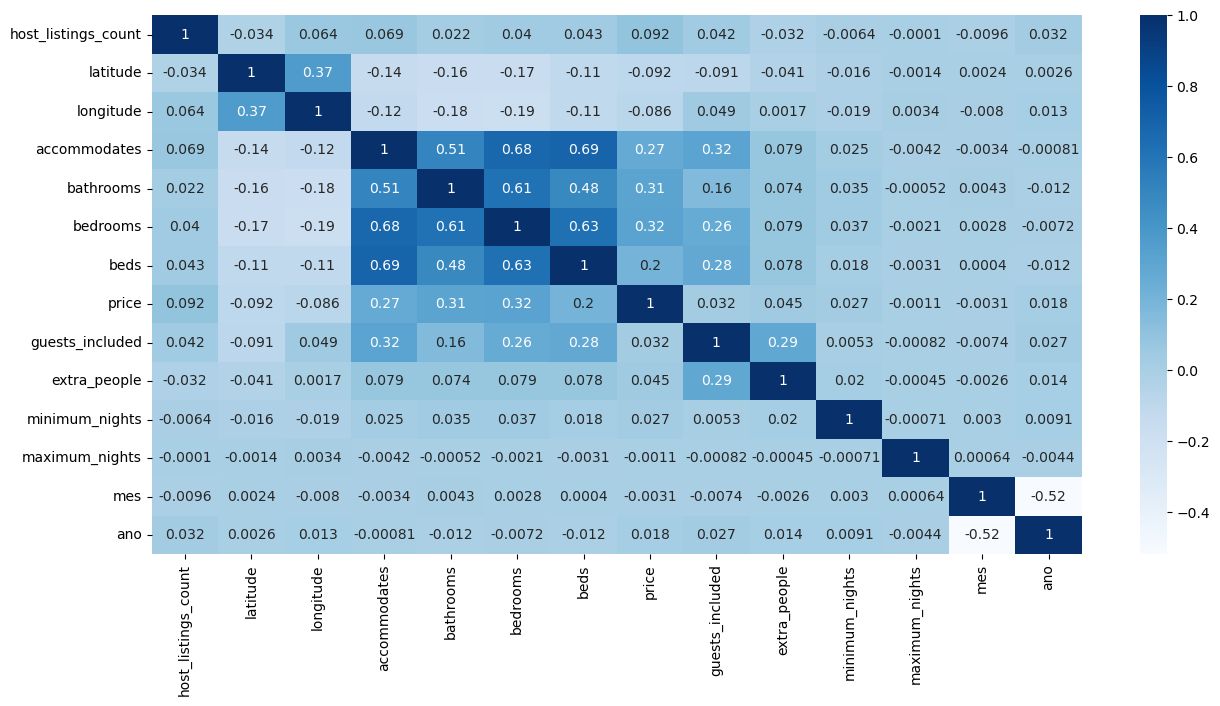

In [155]:
#vendo a correlação entre as features

plt.figure(figsize=(15,7))
sns.heatmap(base_dados.corr(), annot = True, cmap = 'Blues')
plt.show()

Através do gráfico de correlação, foi possível observar que não existe nenhuma coluna que está correlacionada com outra de forma muito forte, então seguiremos com todas essas colunas por enquanto.
Caso existissem colunas fortemente correlacionadas, poderíamos optar por excluir uma delas pois elas representariam valores bem parecidos para o modelo, como se fossem "colunas duplicadas".

### Criando as funções do limite e dos gráficos

In [156]:
# criando a função para determinar os limites inferiores e superiores e determinar os outliers (o que estiver fora do limite)

def limites (coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    limite_inferior = q1 - (1.5*amplitude)
    limite_superior = q3 + (1.5*amplitude)
    return limite_inferior, limite_superior

# criando a função para excluir esses outliers

def excluir_outliers(dataframe, nome_coluna):
    qtd_linhas = dataframe.shape[0]
    limite_inferior, limite_superior = limites(dataframe[nome_coluna])
    dataframe = dataframe.loc[(dataframe[nome_coluna] >= limite_inferior) & (dataframe[nome_coluna] <= limite_superior), :]
    linhas_removidas = qtd_linhas - dataframe.shape[0]
    return dataframe, linhas_removidas


# criando a funçao do boxplot (diagrama de caixas)

def boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    sns.boxplot(x = coluna, ax = ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x = coluna, ax = ax2)
    
#criando a função do histograma

def histograma(coluna):
    plt.figure(figsize = (15,5))
    sns.histplot(coluna, kde = True, stat = 'density', binwidth= 5)
    
#criando função do gráfico de barras para features numéricas

def grafico_barras(coluna):
    plt.figure(figsize = (15,5))
    ax = sns.barplot(x = coluna.value_counts().index, y = coluna.value_counts(), color = 'Blue')
    ax.set_xlim(limites(coluna))
    
#definindo o gráfico de barras para as features de texto

def grafico_barras_texto(dataframe, nome_coluna):
    plt.figure(figsize = (15,5))
    plt.xticks(rotation = 90)
    grafico = sns.barplot(x = dataframe[nome_coluna].value_counts().index, y = dataframe[nome_coluna].value_counts(), color = 'Blue')
    grafico.set_xlabel(nome_coluna)
    grafico.set_ylabel('count')
    plt.show()
    

### Analisando e tratando as features numéricas

#### Price

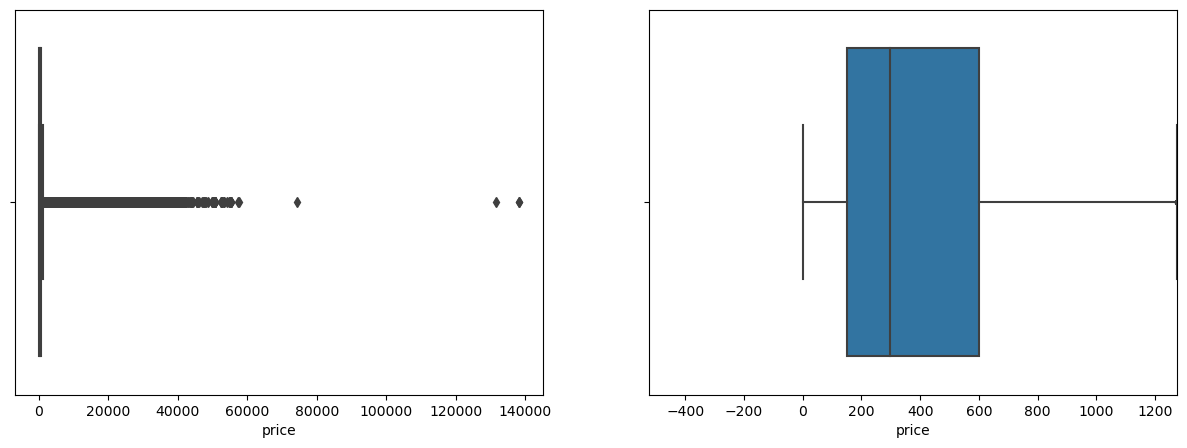

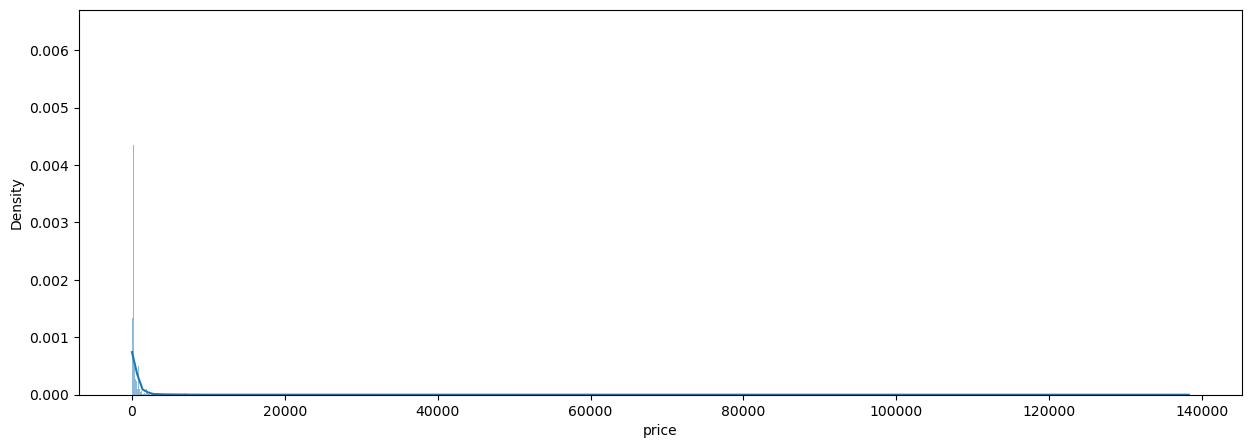

In [157]:
#vendo os dados sem tratamento
boxplot(base_dados['price'])
histograma(base_dados['price'])


In [158]:
#excluindo os outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'price')
print (f'{linhas_removidas} linhas foram excluídas.')


87282 linhas foram excluídas.


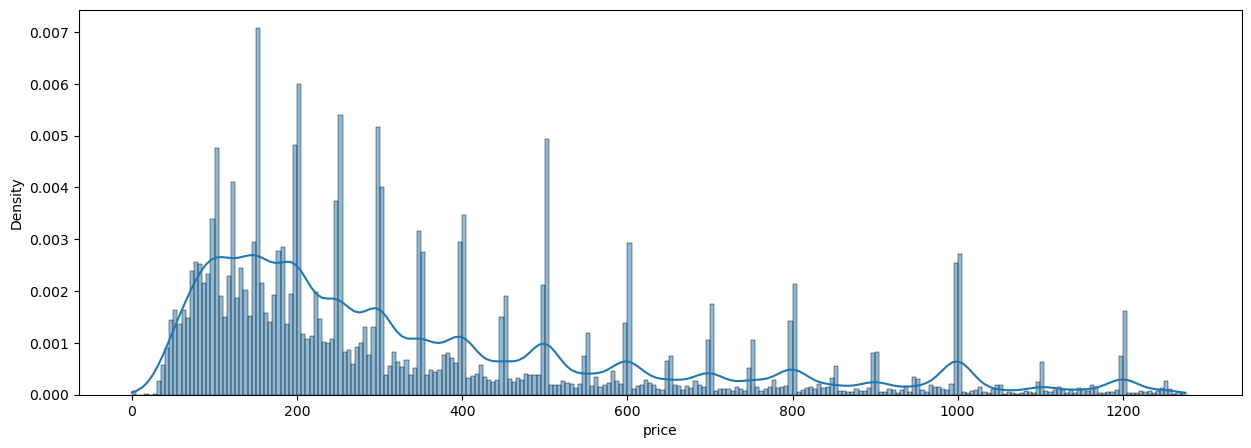

In [159]:
#vendo a distribuiçao dos dados após a retirada de outliers
histograma(base_dados['price'])

Nota-se que ficou bem mais fácil verificar a distribuição dos dados após a retirada dos outliers, pois agora eles estão bem mais concentrados

#### Extra People

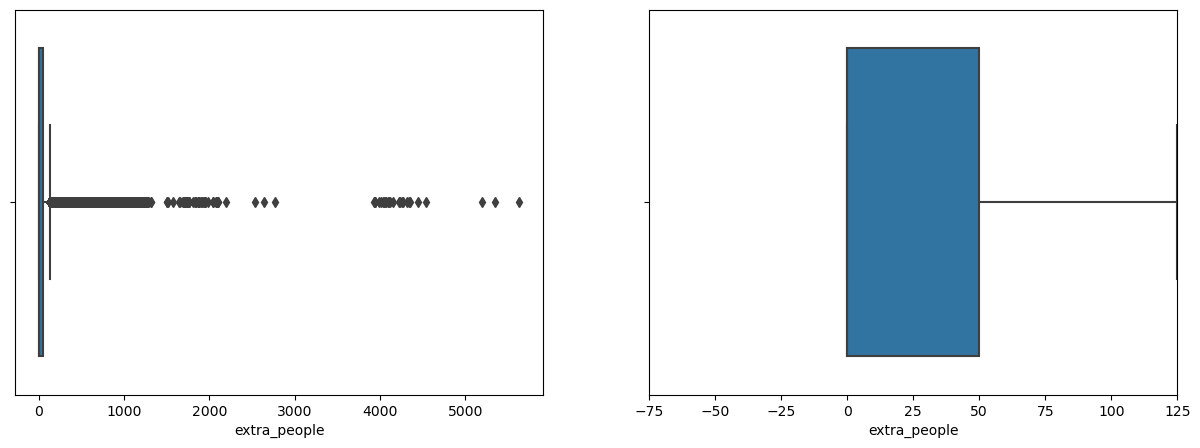

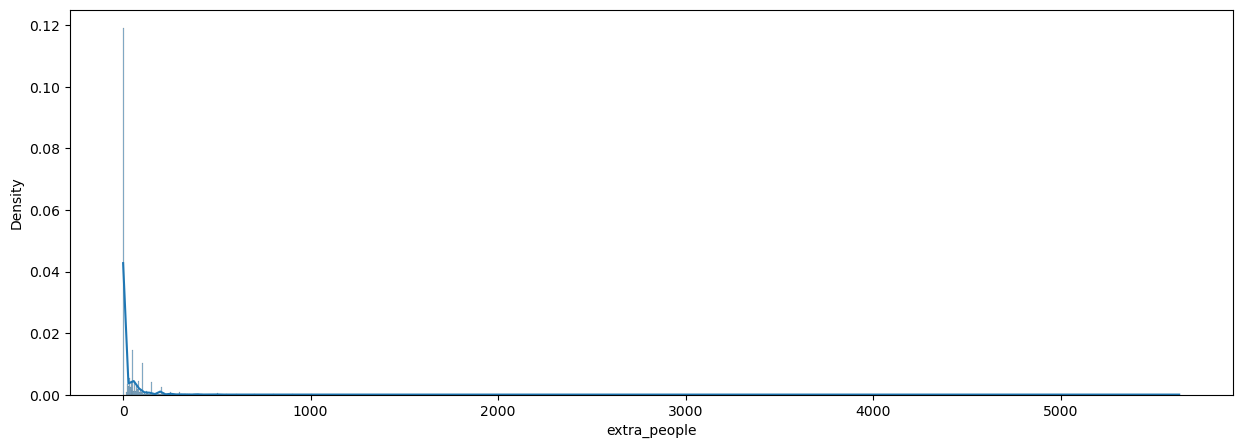

In [160]:
#vendo os dados sem tratamento
boxplot(base_dados['extra_people'])
histograma(base_dados['extra_people'])

In [161]:
#excluindo os outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'extra_people')
print (f'{linhas_removidas} linhas foram excluídas.')

59194 linhas foram excluídas.


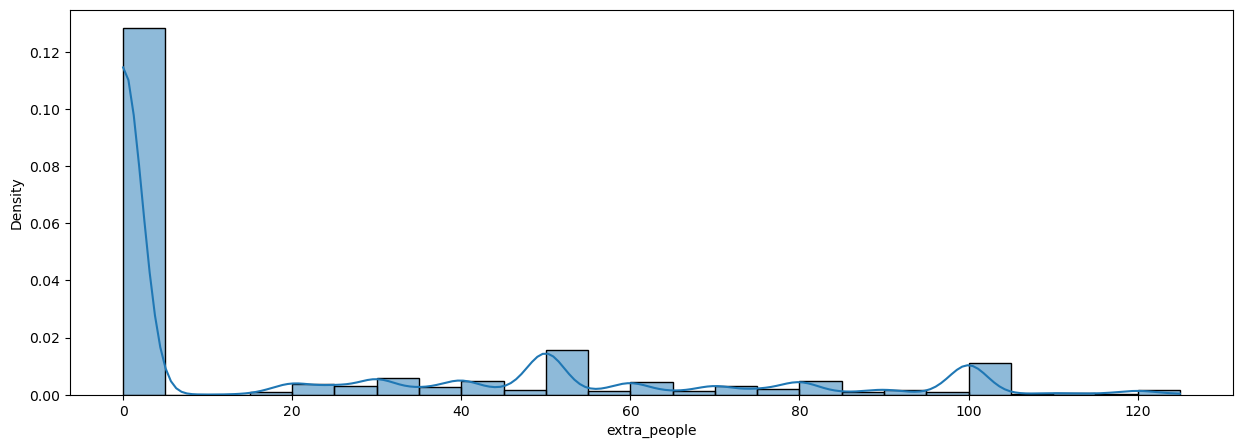

In [162]:
#vendo a distribuição dos dados após a retirada de outliers
histograma(base_dados['extra_people'])

#### host_listings_count

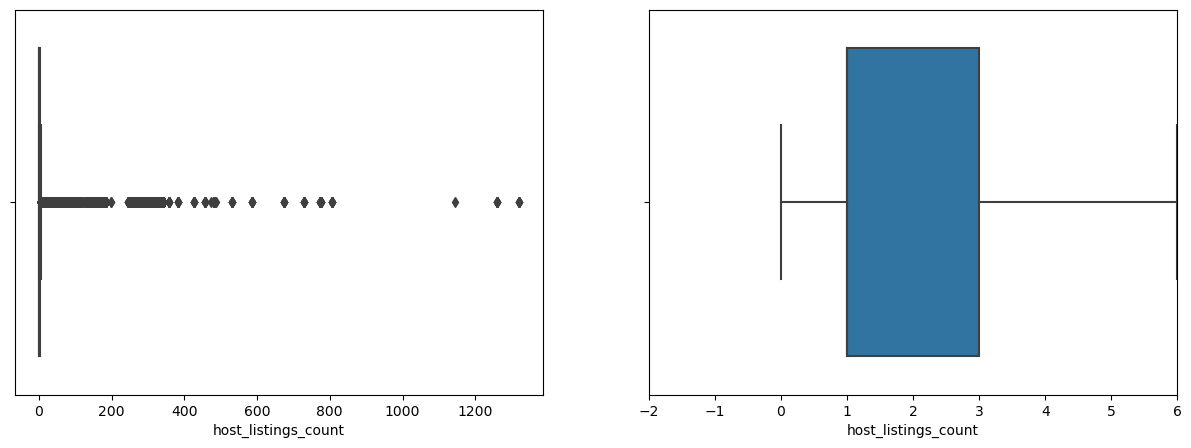

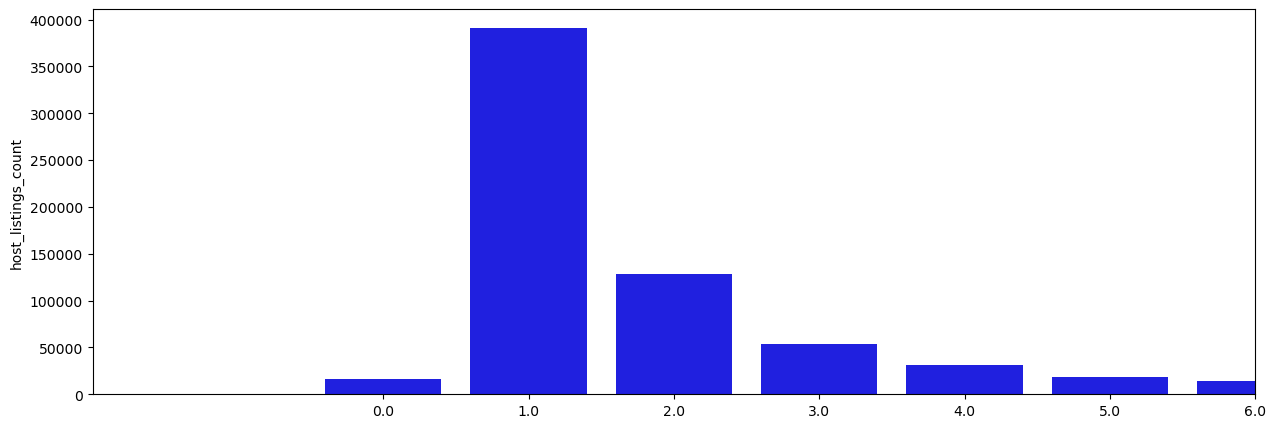

In [163]:
#verificação inicial
boxplot(base_dados['host_listings_count'])
grafico_barras(base_dados['host_listings_count'])

In [164]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'host_listings_count')
print (f'{linhas_removidas} linhas foram excluídas.')

97723 linhas foram excluídas.


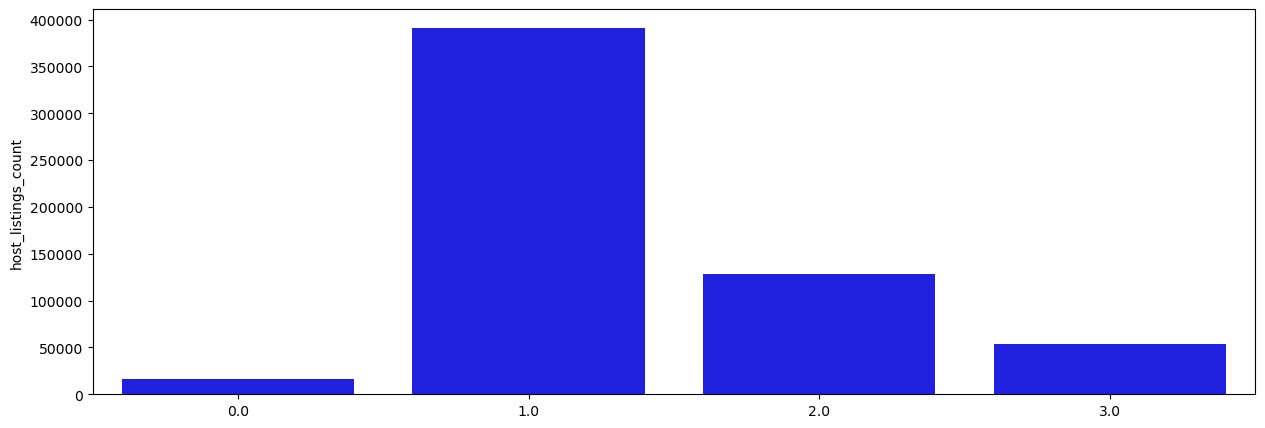

In [165]:
#verificação dos dados após a exclusão dos outliers
grafico_barras(base_dados['host_listings_count'])

#### accommodates 
   

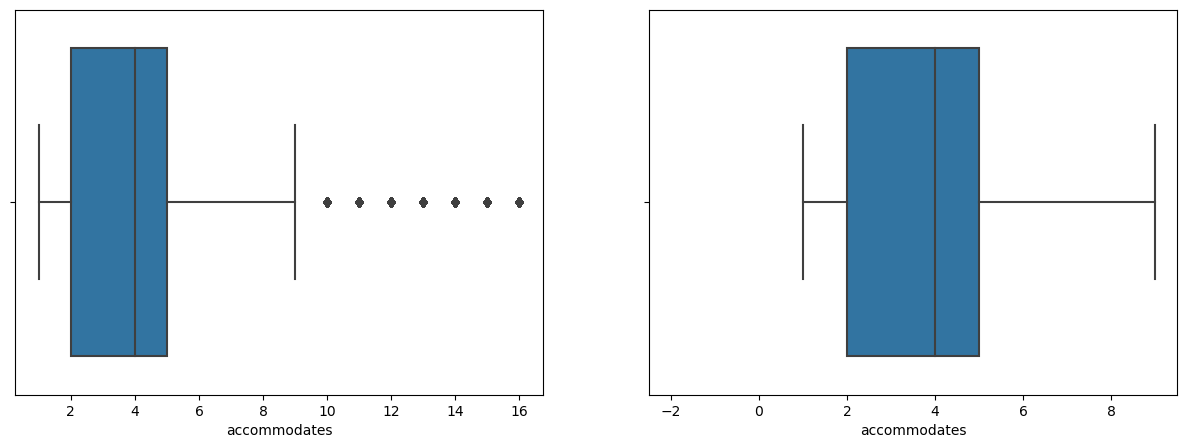

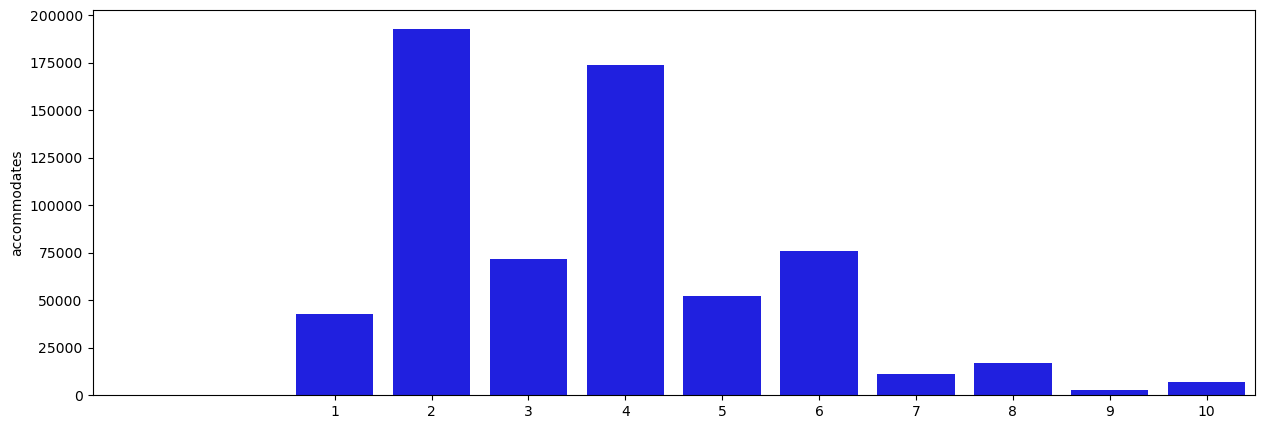

In [166]:
#verificação inicial
boxplot(base_dados['accommodates'])
grafico_barras(base_dados['accommodates'])

In [167]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'accommodates')
print (f'{linhas_removidas} linhas foram excluídas.')

13146 linhas foram excluídas.


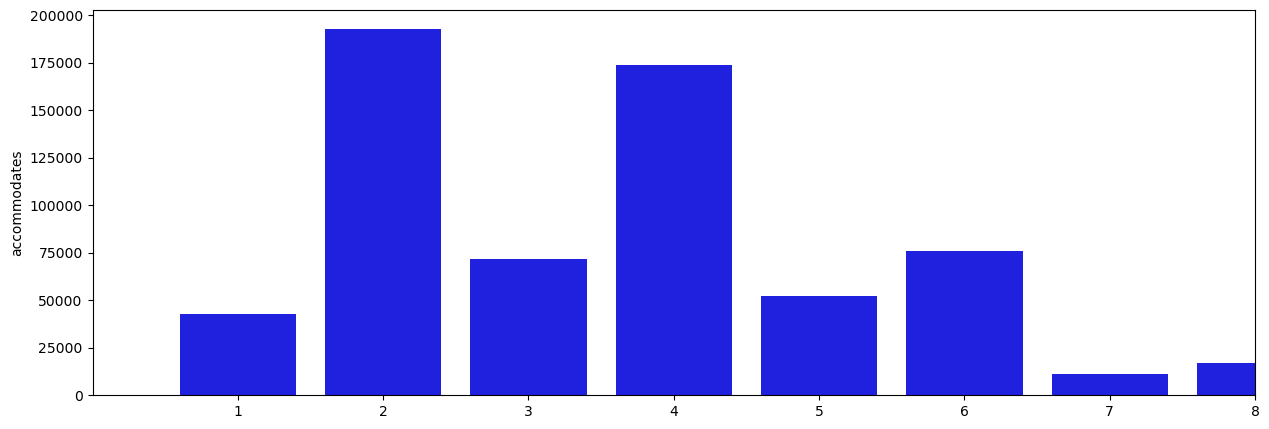

In [168]:
#verificação após retirada de outliers
grafico_barras(base_dados['accommodates'])

#### bathrooms              
        

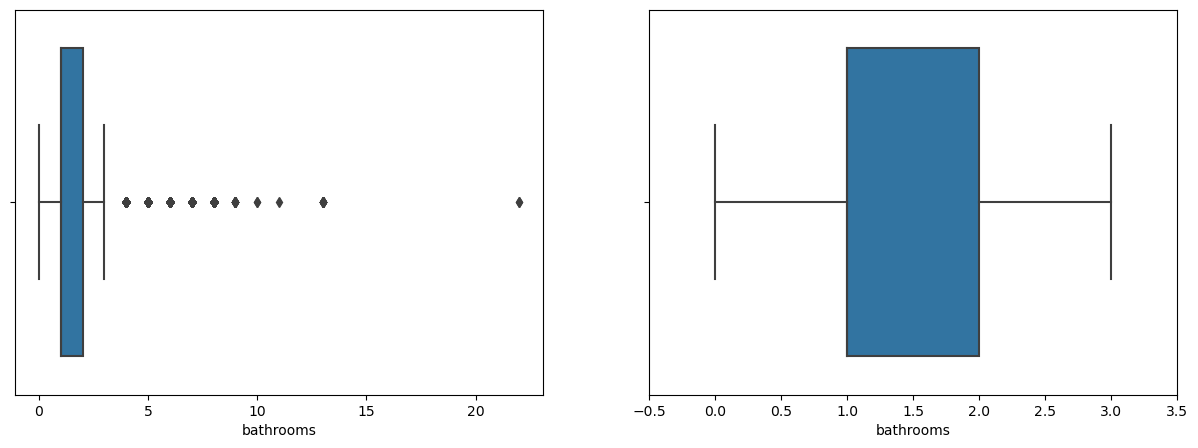

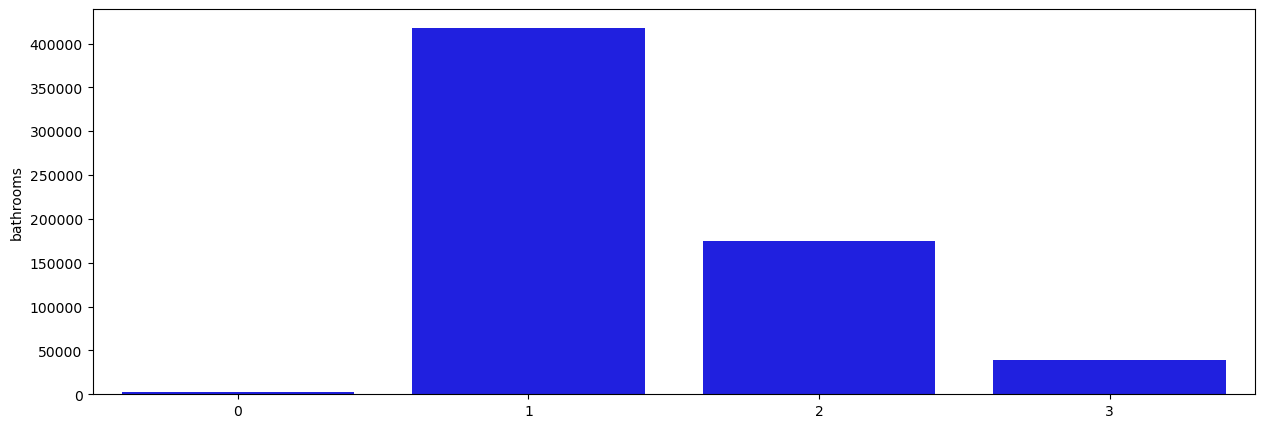

In [169]:
boxplot(base_dados['bathrooms'])
grafico_barras(base_dados['bathrooms'])

In [170]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'bathrooms')
print (f'{linhas_removidas} linhas foram excluídas.')

6894 linhas foram excluídas.


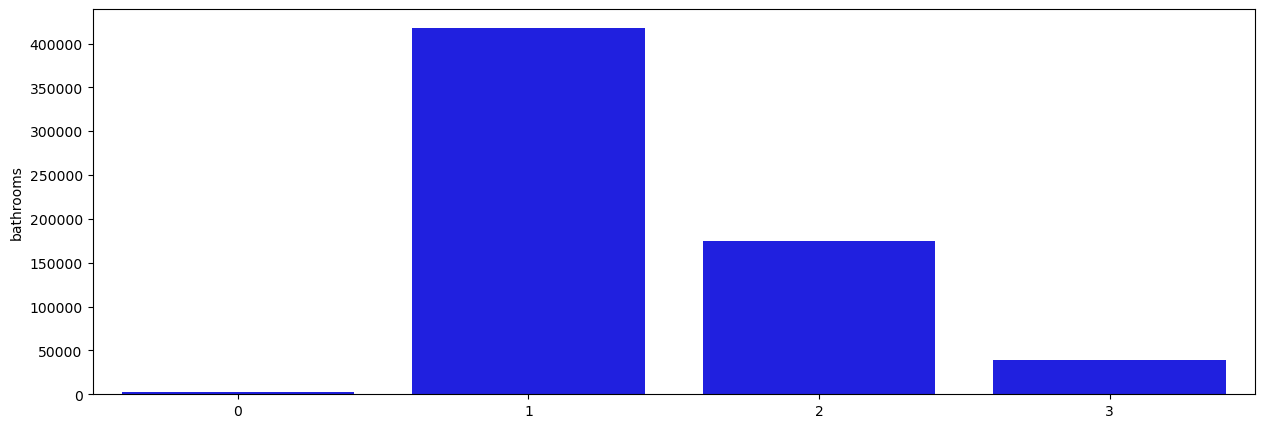

In [171]:
#dados após exclusão de outliers
grafico_barras(base_dados['bathrooms'])

#### bedrooms               


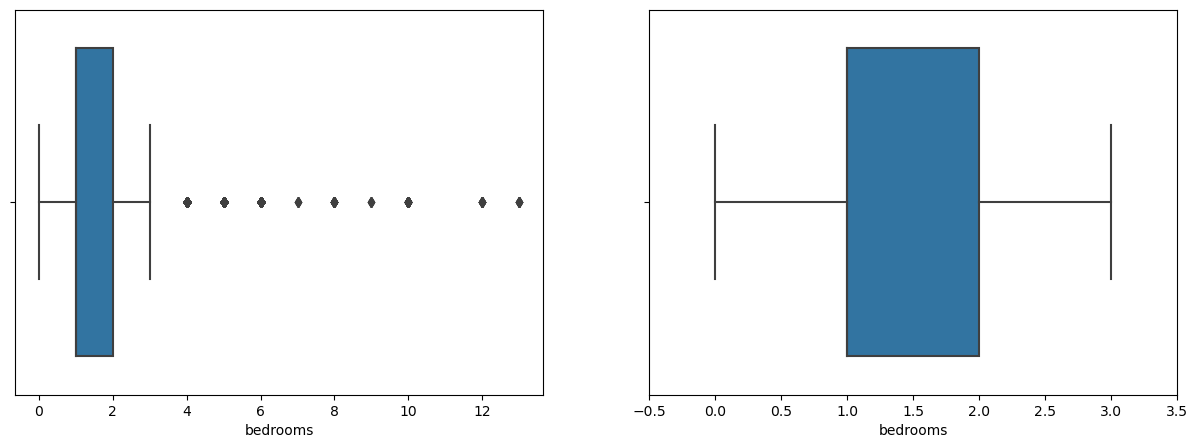

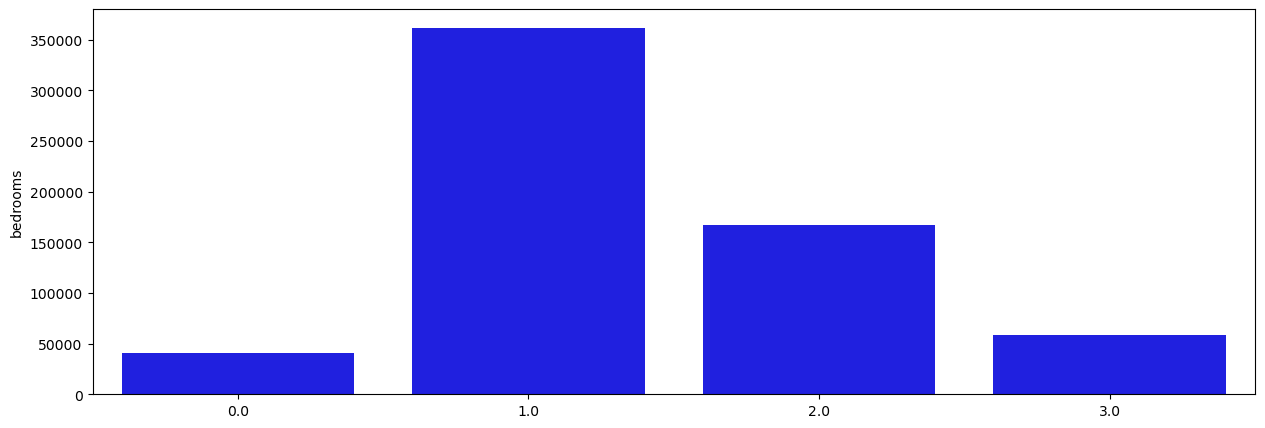

In [172]:
#visualização inicial
boxplot(base_dados['bedrooms'])
grafico_barras(base_dados['bedrooms'])

In [173]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'bedrooms')
print (f'{linhas_removidas} linhas foram excluídas.')

5482 linhas foram excluídas.


Nesse caso, como já retiramos várias linhas ao tratarmos outras colunas, já não existiam mais outliers para a feature de bedrooms (pode-se verificar isso inclusive olhando o boxplot, pois não existem dados visíveis fora dos limites

### beds                   

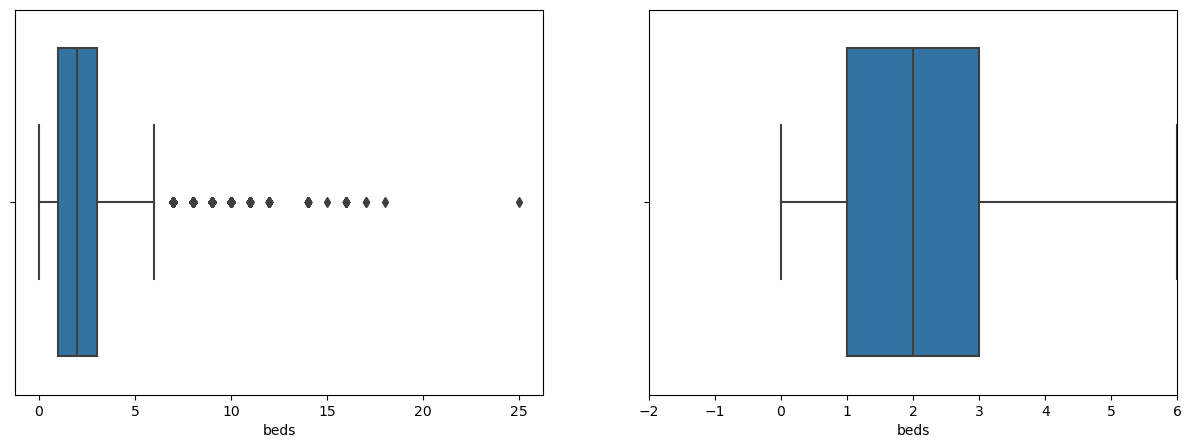

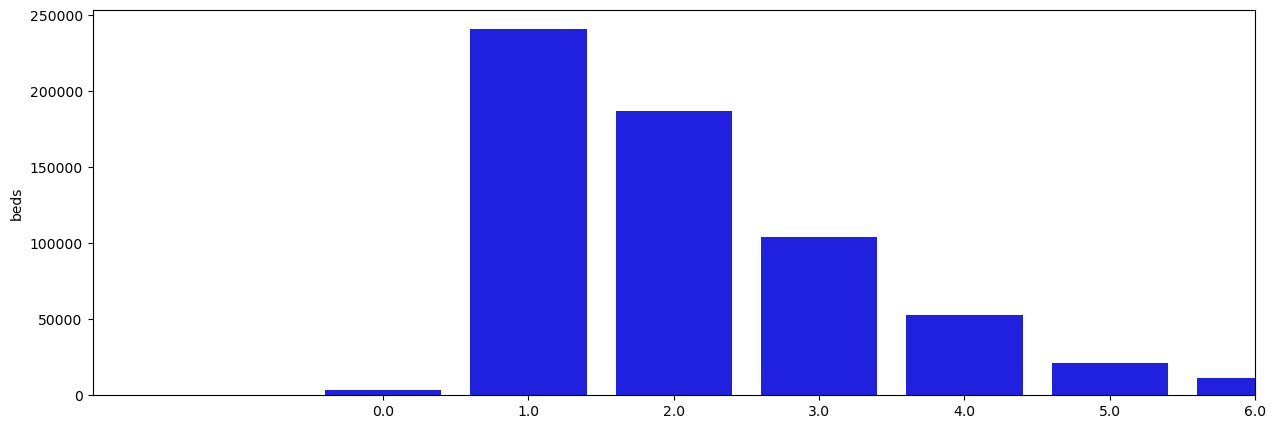

In [174]:
#visualização inicial
boxplot(base_dados['beds'])
grafico_barras(base_dados['beds'])

In [175]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'beds')
print (f'{linhas_removidas} linhas foram excluídas.')

5622 linhas foram excluídas.


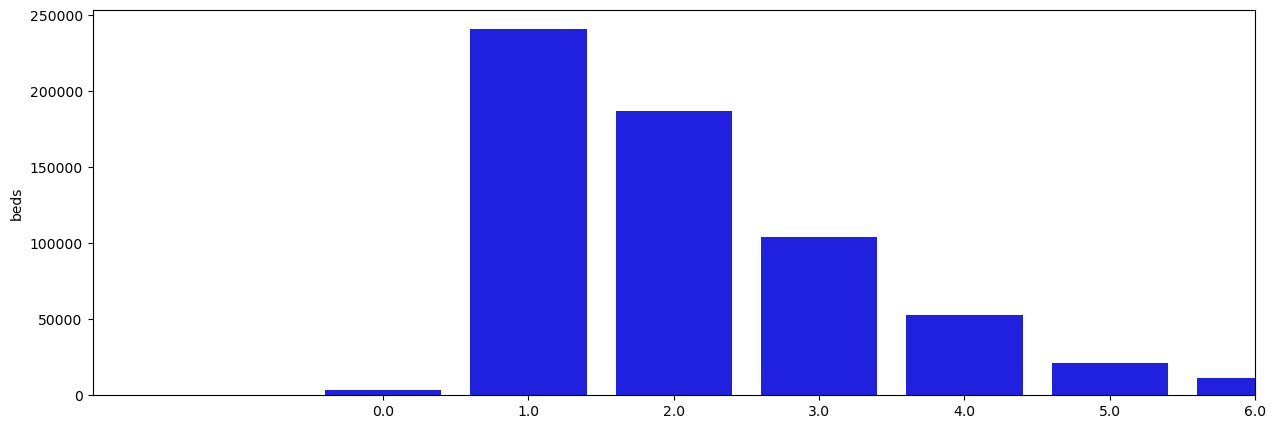

In [176]:
#verificação final da distribuição
grafico_barras(base_dados['beds'])

### guests_included          

C:\Users\bruno\AppData\Local\Temp\ipykernel_1616\2723286013.py:27: UserWarning:

Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.

C:\Users\bruno\AppData\Local\Temp\ipykernel_1616\2723286013.py:41: UserWarning:

Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.



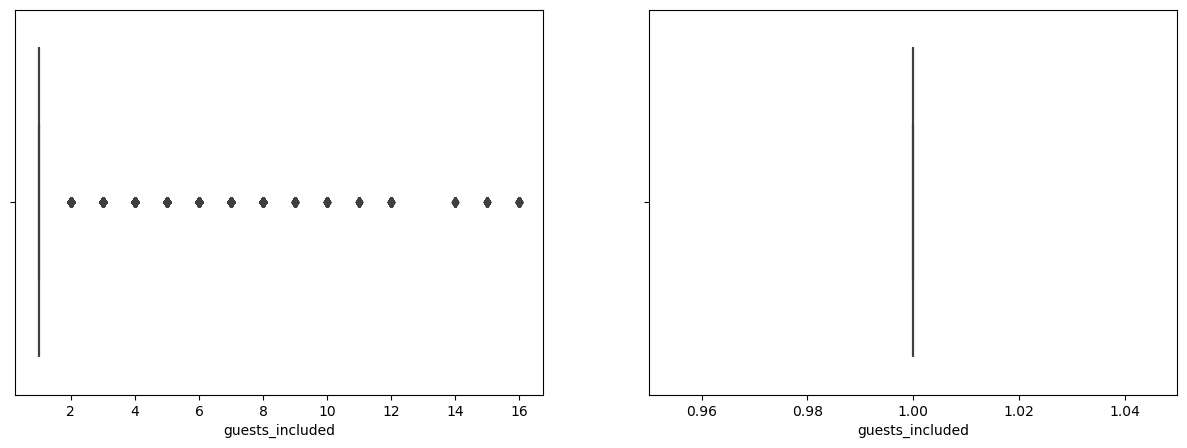

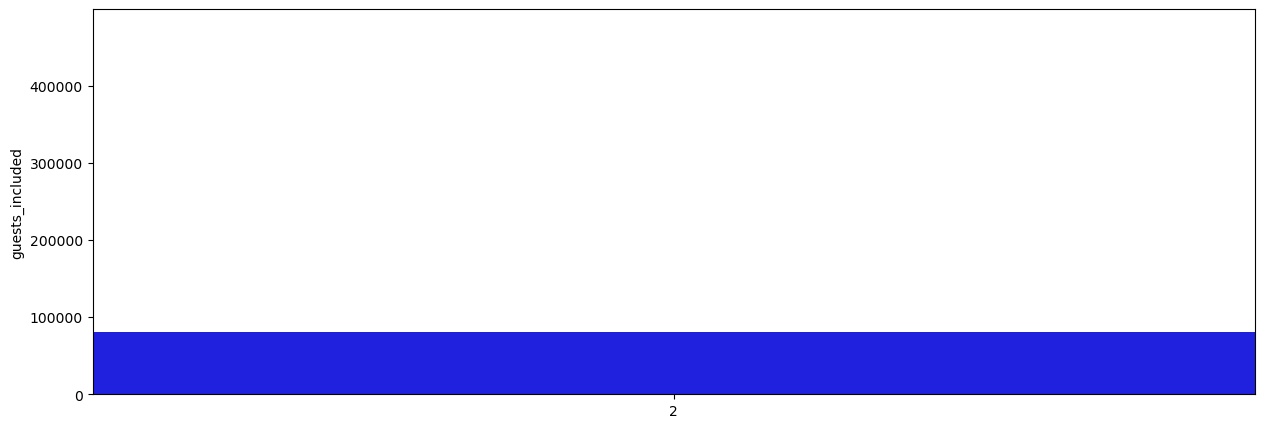

In [177]:
boxplot(base_dados['guests_included'])
grafico_barras(base_dados['guests_included'])

#vamos excluir essa coluna pois tanto o limite inferior quando o superior estão dando 1. Logo, se excluirmos os outliers, estaremos levando em conta que todas as casas só podem ter 1 visitante
# então vamos excluir essa coluna para ela não atrapalhar nossa análise

base_dados = base_dados.drop('guests_included', axis = 1)

### minimum_nights           


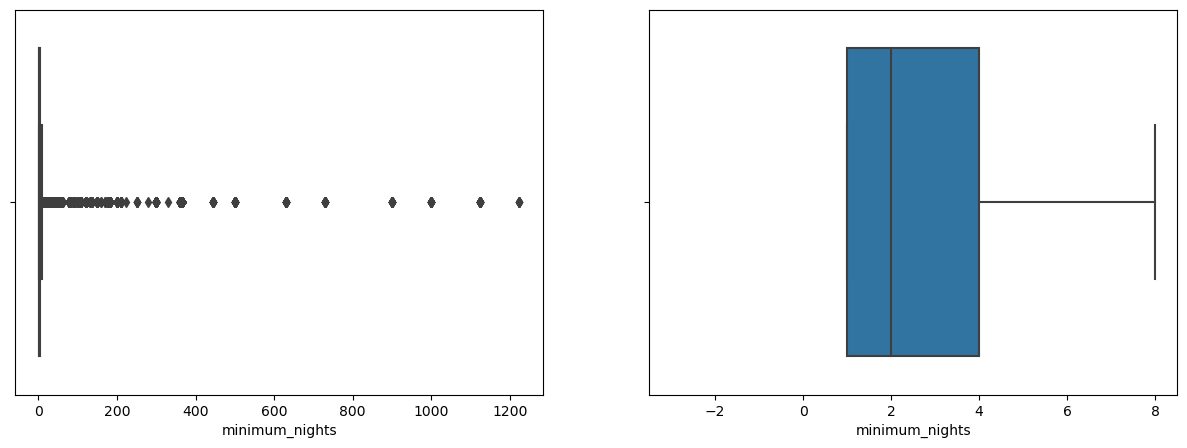

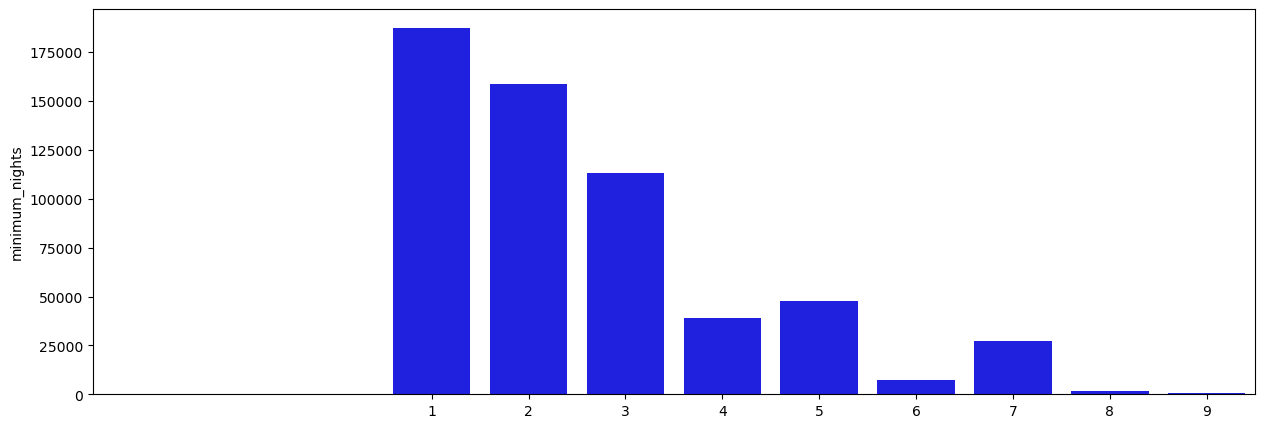

In [178]:
#visualização inicial
boxplot(base_dados['minimum_nights'])
grafico_barras(base_dados['minimum_nights'])

In [179]:
#exclusão de outliers
base_dados, linhas_removidas = excluir_outliers(base_dados, 'minimum_nights')
print (f'{linhas_removidas} linhas foram excluídas.')

40383 linhas foram excluídas.


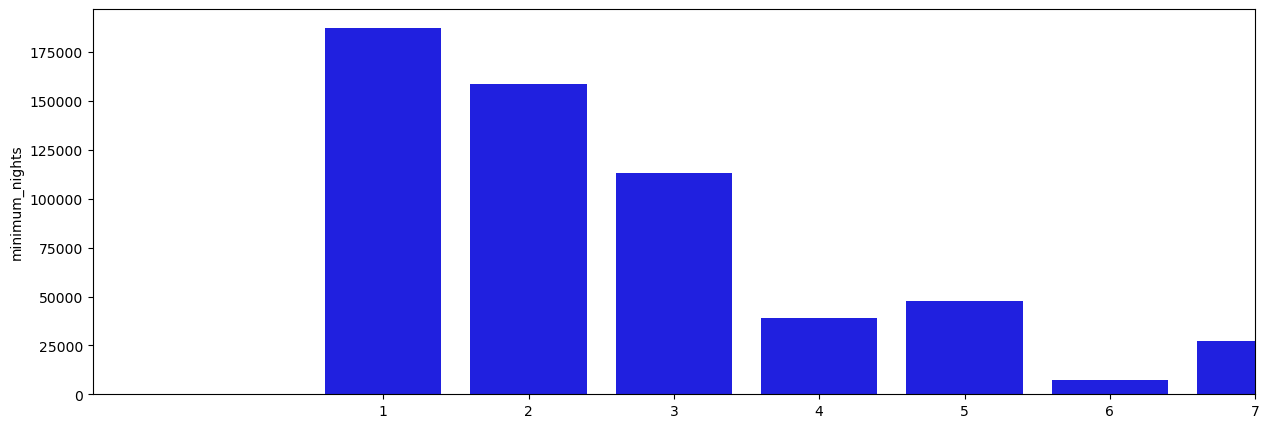

In [180]:
#verificação final
grafico_barras(base_dados['minimum_nights'])

### maximum_nights

In [181]:
base_dados['maximum_nights'].head(30)

1       90
3       30
4     1125
5       89
6       30
8      730
16    1125
18    1125
21      30
23      89
24     365
26     420
27       8
29     120
30     365
36      10
37     365
39      60
40      60
41     730
44      60
45      90
46     365
49    1125
52      21
53      20
56      60
57     500
58     730
60     730
Name: maximum_nights, dtype: int64

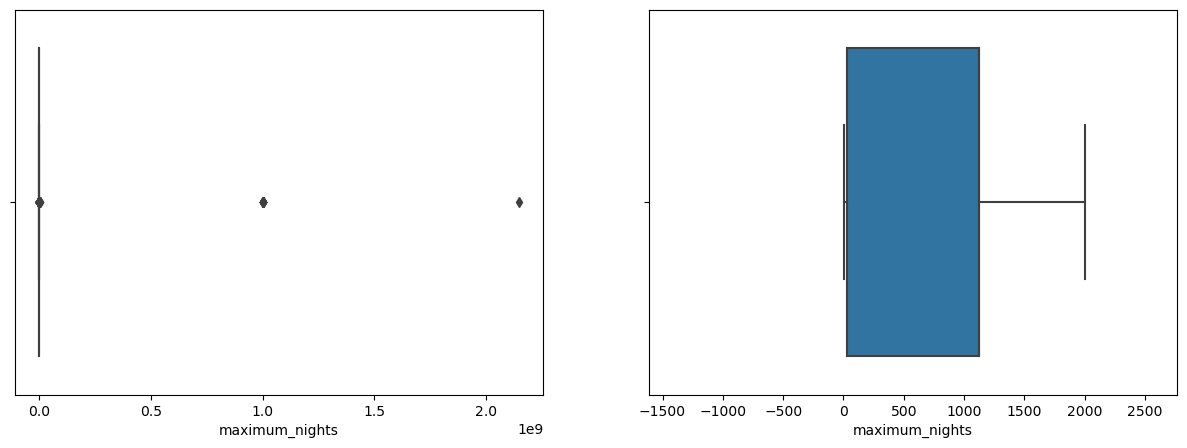

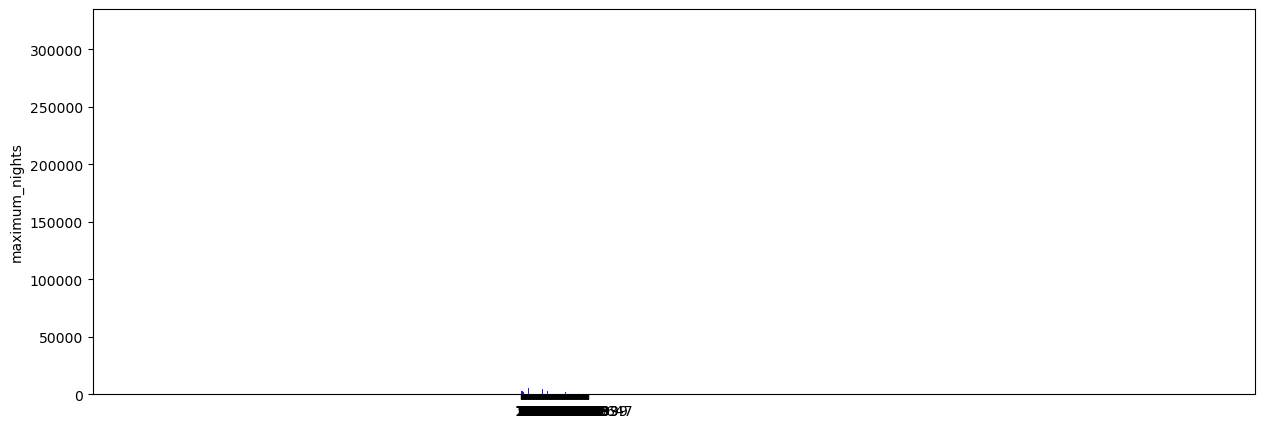

In [182]:
boxplot(base_dados['maximum_nights'])
grafico_barras(base_dados['maximum_nights'])


Os dados de maximum_nights estão preenchidos de forma um pouco confusa e sem padrão, o que pode acabar atrapalhando nossa análise. Vamos retirar esse coluna

In [183]:
base_dados = base_dados.drop ('maximum_nights', axis = 1)

### Tratando os valores de texto

### property_type           


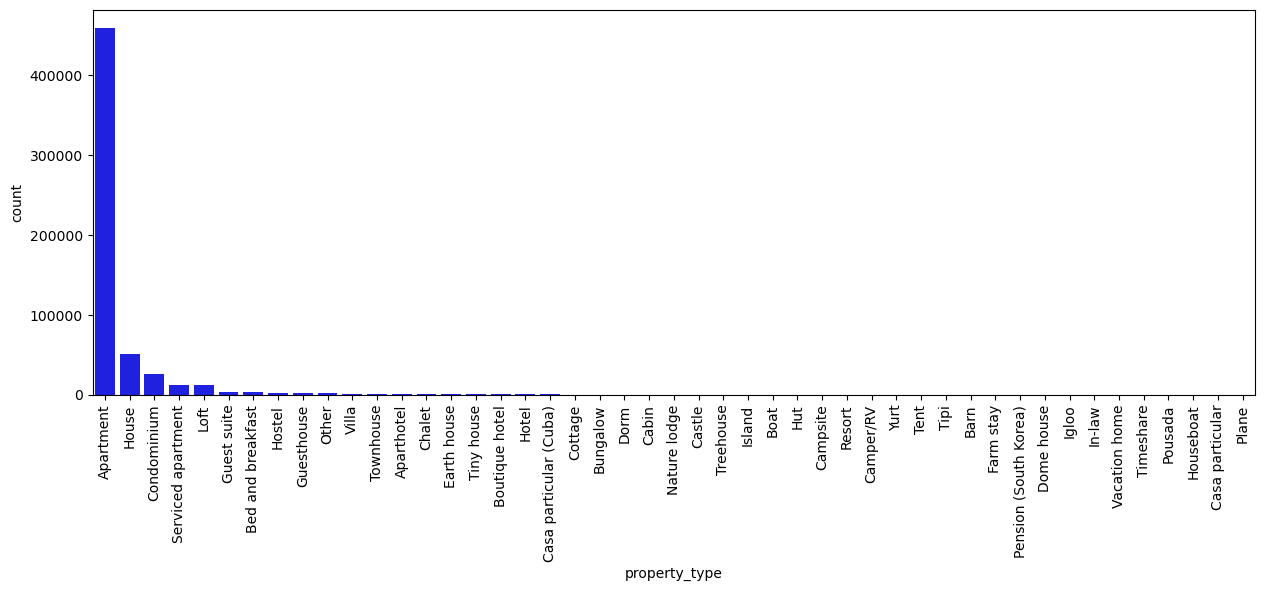

In [184]:
#gerando o gráfico para ver como está a distribuição da feature

grafico_barras_texto(base_dados, 'property_type')


In [185]:
#agrupando os itens de menor expressividade
tipos_para_agrupar = []
tabela_tipos_casa = base_dados['property_type'].value_counts()
print(tabela_tipos_casa)

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] <= 2000:
        tipos_para_agrupar.append(tipo)

for tipo in tipos_para_agrupar:
    base_dados.loc[base_dados['property_type']==tipo, 'property_type'] = 'Others'

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

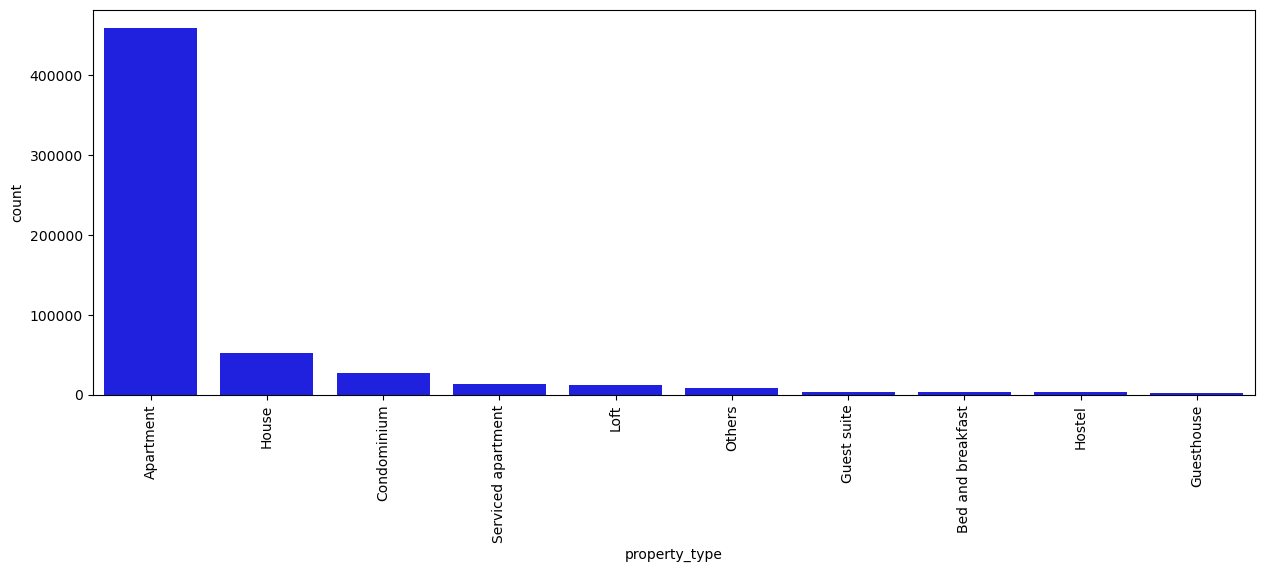

In [186]:
#gerando o gráfico novamente para ver como ficou

grafico_barras_texto(base_dados, 'property_type')



### room_type               


Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


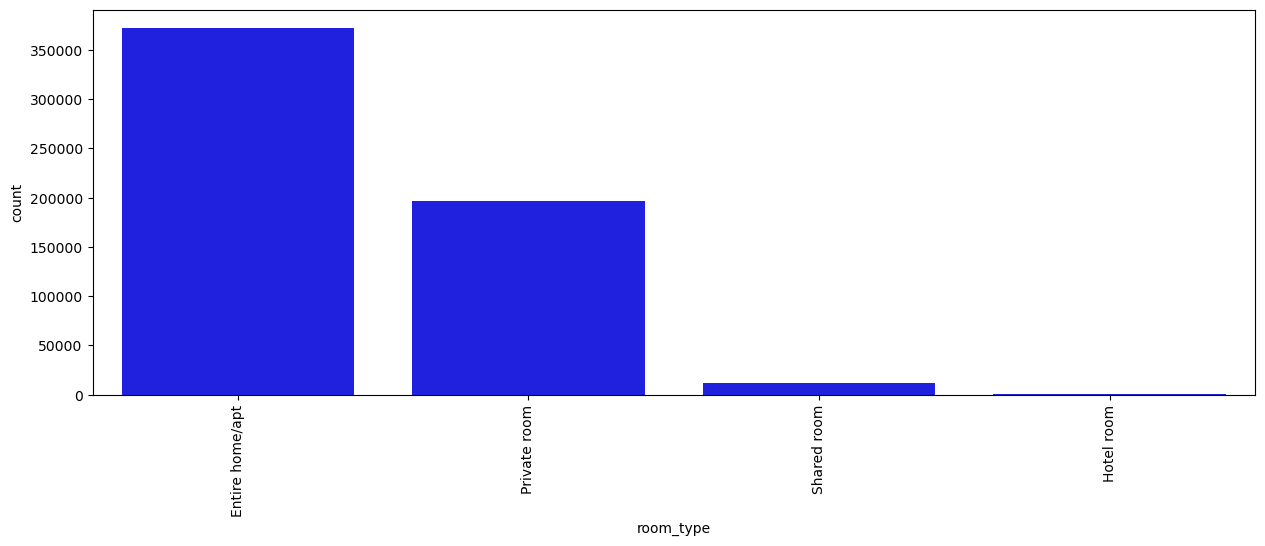

In [187]:
print(base_dados['room_type'].value_counts())

grafico_barras_texto(base_dados, 'room_type')

### bed_type                

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


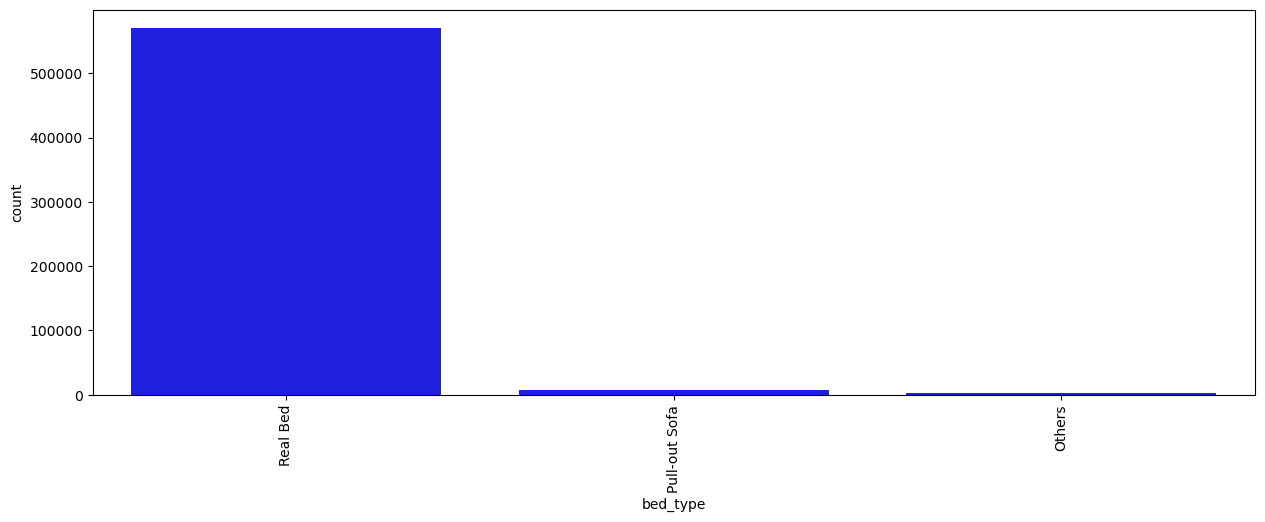

In [188]:
print(base_dados['bed_type'].value_counts())

#agrupando os itens de menor expressividade
camas_para_agrupar = []
tabela_tipos_cama = base_dados['bed_type'].value_counts()


for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] <= 2000:
        camas_para_agrupar.append(tipo)

for tipo in camas_para_agrupar:
    base_dados.loc[base_dados['bed_type']==tipo, 'bed_type'] = 'Others'
    
grafico_barras_texto(base_dados, 'bed_type')



### cancellation_policy    

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


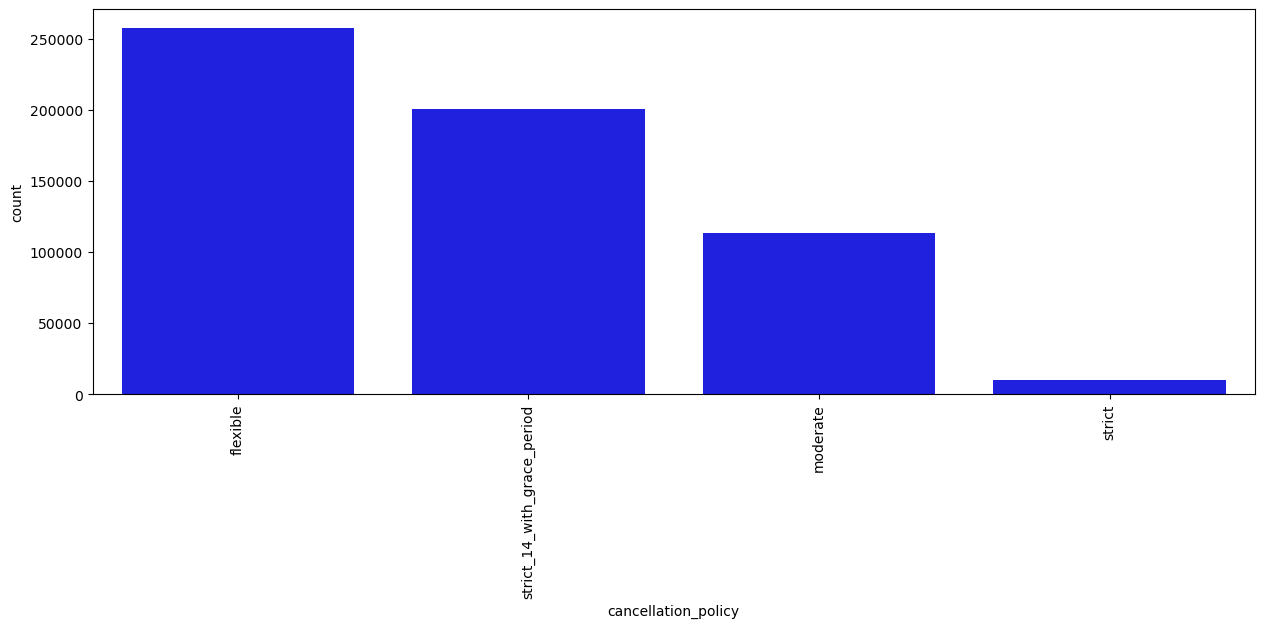

In [189]:
print(base_dados['cancellation_policy'].value_counts())

lista_agrupar_politicas = []
tabela_politicas = base_dados['cancellation_policy'].value_counts()

for politica in tabela_politicas.index:
    if tabela_politicas[politica] <= 10000:
        lista_agrupar_politicas.append(politica)

for politica in lista_agrupar_politicas:
    base_dados.loc[base_dados['cancellation_policy']==politica, 'cancellation_policy'] = 'strict'
#optei por agrupar esses valores com o nome de 'strict' ao invés de 'outros' 
    

grafico_barras_texto(base_dados, 'cancellation_policy')

### amenities               

In [190]:
#temos amenities escritos de diversas formas para cada propriedade. Logo, será dificil de analisar o texto.
# a solução encontrada foi transformar os amenities em quantidade e então deixar o modelo de previsão trabalhar com essa quantidade


base_dados['amenities'] = base_dados['amenities'].str.split(',')
base_dados['num_amenities'] = base_dados['amenities'].apply(len)



24343 linhas foram excluídas.


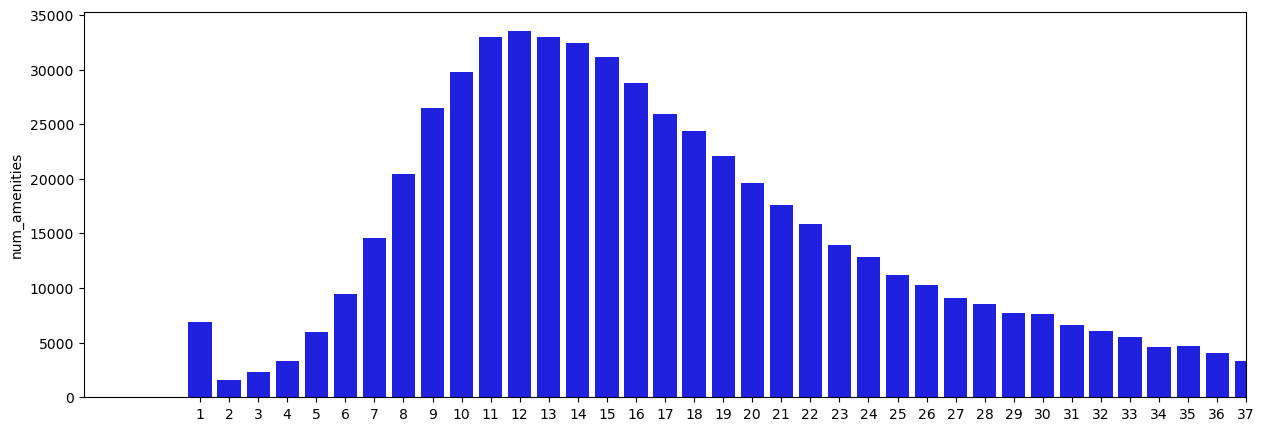

In [191]:
#excluindo a coluna amenities (pois iremos utilizar a nova coluna) e retirando os outliers da coluna num_amenities

base_dados = base_dados.drop('amenities', axis = 1)

base_dados, linhas_removidas = excluir_outliers(base_dados, 'num_amenities')
print (f'{linhas_removidas} linhas foram excluídas.')

grafico_barras(base_dados['num_amenities'])





### Visualização dos preços no mapa

In [192]:
#primeiro, vamos definir uma quantidade amostral pois se utilizarmos a quantidade total de dados, o mapa fica muito embolado, dificil de visualizar (e também pesado)

amostra = base_dados.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat = 'latitude', lon = 'longitude', z = 'price', radius = 2.5, 
                        center = centro_mapa, zoom = 10, mapbox_style = 'stamen-terrain')

mapa.show()


### Encoding

Os modelos de machine learning só conseguem aprender utilizando números. Logo, vamos transformar as células de texto para valores numéricos.

Os valores de True or False são transformados para 0 ou 1.

As colunas de texto compostas por várias categorias, são transformadas em "variáveis dummies". Que seria basicamente adicionar colunas no gráfico, onde o nome da coluna é a própria variável e ela tbm recebe o valor de 0 ou 1 de acordo se ela é a variável que está na coluna original ou não.
O pandas tem um método que faz isso rapidamente, que é o pd.get_dummies

#### Colunas verdadeiro ou falso

In [193]:
colunas_true_or_false = ['host_is_superhost']

base_dados_encoding = base_dados.copy()

for coluna in colunas_true_or_false:
    base_dados_encoding.loc[base_dados_encoding[coluna] == 't', coluna] = 1
    base_dados_encoding.loc[base_dados_encoding[coluna] == 'f', coluna] = 0
    

#### Colunas de categorias

In [194]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

base_dados_encoding = pd.get_dummies(data = base_dados_encoding, columns = colunas_categorias)

display (base_dados_encoding.head())



host_listings_count host_is_superhost   latitude  longitude  accommodates  \
1                  2.0                 1 -22.965919 -43.178962             5   
3                  3.0                 0 -22.977117 -43.190454             3   
4                  1.0                 1 -22.983024 -43.214270             3   
5                  1.0                 1 -22.988165 -43.193588             3   
6                  1.0                 1 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  room_type_Hotel room  \
1          1       2.0   2.0  270.0          51.0  ...                     0   
3          1       1.0   2.0  161.0          45.0  ...                     0   
4          1       1.0   2.0  222.0          68.0  ...                     0   
5          1       1.0   2.0  308.0          86.0  ...                     0   
6          1       1.0   2.0  219.0          80.0  ...                     0   

   room_type_Private room  room_type_Shared room  bed_type_Others  \
1                       0                      0                0   
3                       0                      0                0   
4                       0                      0                0   
5                       0                      0                0   
6                       0                      0                0   

   bed_type_Pull-out Sofa  bed_type_Real Bed  cancellation_policy_flexible  \
1                       0                  1                             0   
3                       0                  1                             0   
4                       0                  1                             0   
5                       0                  1                             0   
6                       0                  1                             0   

   cancellation_policy_moderate  cancellation_policy_strict  \
1                             0                           1   
3                             0                           1   
4                             0                           1   
5                             0                           1   
6                             0                           1   

   cancellation_policy_strict_14_with_grace_period  
1                                                0  
3                                                0  
4                                                0  
5                                                0  
6                                                0  

[5 rows x 35 columns]

### Modelo de Previsão

- Métricas de Previsão

In [195]:
def avaliar_modelo(nome_modelo, y_teste, previsão):
    r2 = r2_score(y_teste, previsão)
    RSME = np.sqrt(mean_squared_error(y_teste, previsão))
    return f'Modelo: {nome_modelo}\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

- Escolha dos modelos a serem testados:
    1. Linear Regression
    2. RandomForest
    3. Extra Trees

In [196]:
#criação das instâncias dos modelos
modelo_lr = LinearRegression()
modelo_rf = RandomForestRegressor()
modelo_et = ExtraTreesRegressor()

modelos = {'LinearRegression': modelo_lr, 'RandomForest': modelo_rf, 'ExtraTrees': modelo_et}

#separação da base de dados em x (as features) e y (que seria a reposta que queremos prever)
y = base_dados_encoding['price']
x = base_dados_encoding.drop('price', axis = 1)

- Separar as variáveis em treino e teste e treinar os modelos

Serve para conseguirmos treinar nosso modelo e depois testar se está funcionando bem, se tem boa eficácia/eficiência.

Obs: o random_state serve apenas para que os valores de treino e teste sejam sempre os mesmos em todas as vezes que eu rodar o código. Caso eu não passe o parâmetro do random state, esses valores serão aleatórias em cada vez que eu rodar o código. Ou seja, funciona normalmente sem o random_state

In [197]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 1)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsão = modelo.predict(x_test)
    print (avaliar_modelo(nome_modelo, y_test, previsão))

Modelo: LinearRegression
R²: 32.03%
RSME: 217.75
Modelo: RandomForest
R²: 97.21%
RSME: 44.11
Modelo: ExtraTrees
R²: 97.56%
RSME: 41.22


### Análise do Melhor Modelo

O melhor modelo encontrado foi o ExtraTrees, pois demonstrou um maior valor de R² e um menor valor de RSME.

Vamos então verificar a importância de cada feature para esse modelo

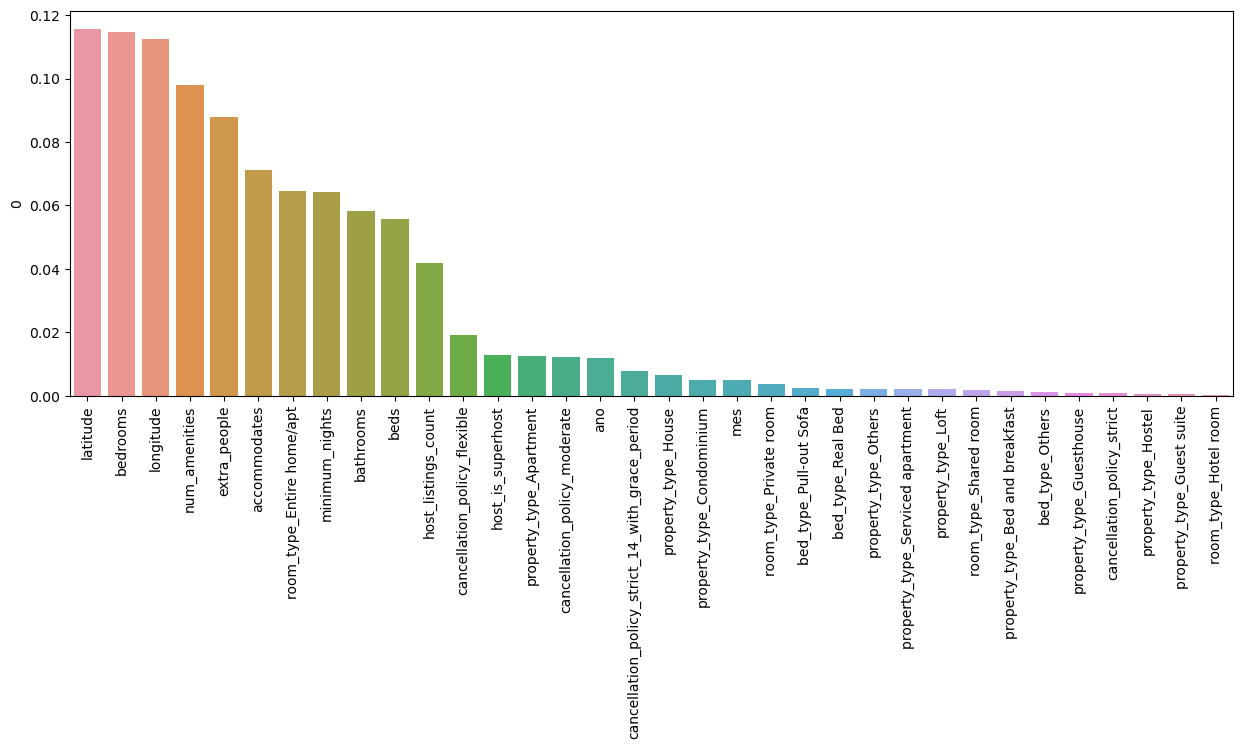

In [198]:
dataframe_importancia = pd.DataFrame(index = x.columns, data = modelo_et.feature_importances_)
dataframe_importancia = dataframe_importancia.sort_values(by = 0, ascending = False)

plt.figure(figsize = (15,5))
sns.barplot (x = dataframe_importancia.index, y = dataframe_importancia[0])
plt.xticks(rotation = 90)
plt.show()

### Ajustes e Melhorias no Melhor Modelo

Optei por remover as colunas de bed_type (pois aparentemente elas não tem grande importância para o modelo) para verificar se o modelo continua trabalhando bem sem elas (dessa forma, iremos simplificar o modelo buscando continuar com excelentes resultados)


In [199]:
base_dados_teste = base_dados_encoding.copy()
for coluna in base_dados_teste:
    if 'bed_type' in coluna:
        base_dados_teste = base_dados_teste.drop(coluna, axis = 1)

#treinando e testando o melhor modelo depois de retirar as colunas

x = base_dados_teste.drop('price', axis = 1)
y = base_dados_teste['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1)

modelo_et.fit(x_train, y_train)
previsão = modelo_et.predict(x_test)
print (avaliar_modelo('ExtraTrees', y_test, previsão))



Modelo: ExtraTrees
R²: 97.55%
RSME: 41.37


Foi confirmado que podemos retirar as colunas de bed_type sem diminuir a qualidade do resultado

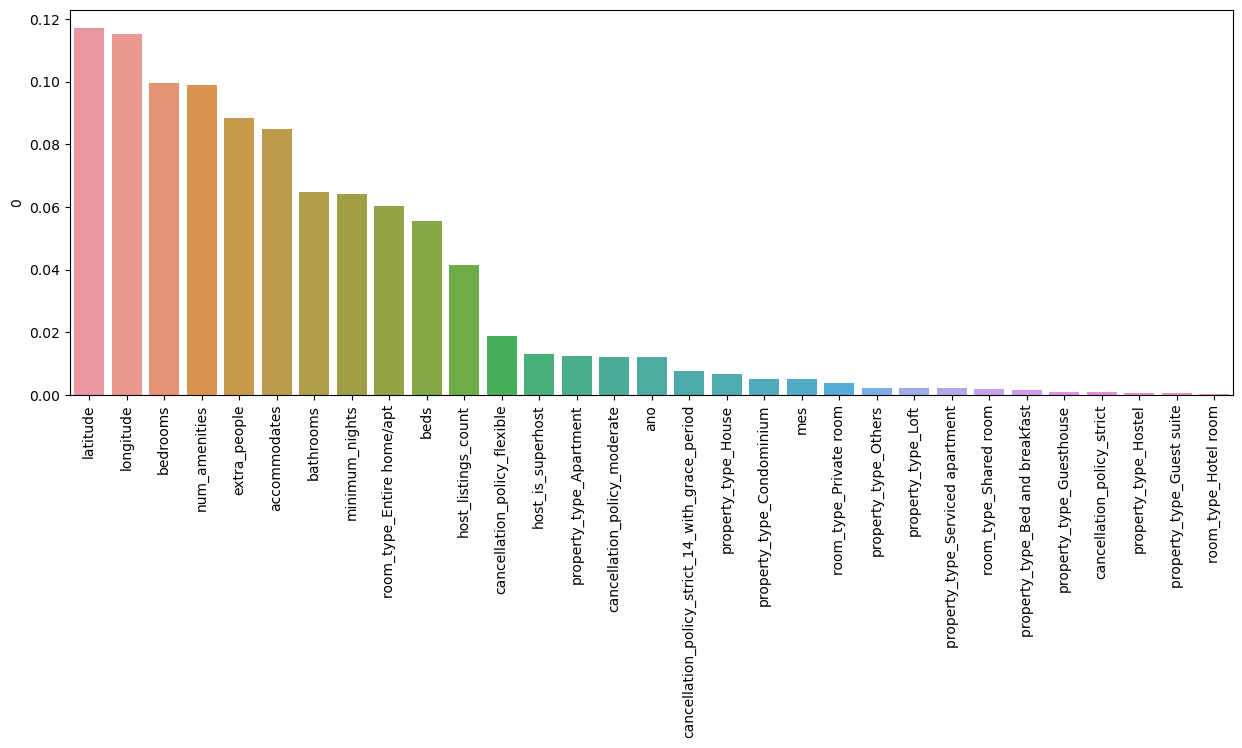

In [200]:
#verificando novamente a importância das features
dataframe_importancia = pd.DataFrame(index = x.columns, data = modelo_et.feature_importances_)
dataframe_importancia = dataframe_importancia.sort_values(by = 0, ascending = False)

plt.figure(figsize = (15,5))
sns.barplot (x = dataframe_importancia.index, y = dataframe_importancia[0])
plt.xticks(rotation = 90)
plt.show()

As features que tem mais impacto para o cálculo do valor da diária por esse modelo são: latitude, longitude, bedrooms e num_amenieis. Porém, várias outras features continuam tendo bastante importância.

### Dar Deploy (transformar em algo visual e que outras pessoas consigam utilizar)

#### Salvando a base de dados tratada para não precisar fazer todo o tratamento dentro do programa

In [201]:
base_dados_teste.to_csv('dados_finais.csv')

#### Salvando o modelo utilizando o joblib para conseguirmos prosseguir com o deploy em outro arquivo

In [202]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib')


## para o resto do deploy, foi criado um outro arquivo

['modelo.joblib']